## Import Packages

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import log_loss, f1_score, roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import lightgbm as lgb
import optuna

## Set file paths for train and predict datasets

In [2]:
train_dataset = "Dataset/Train.csv"
predict_dataset = "Dataset/Test.csv"

## Exploratory Data Analysis

#### Get train dataset info

In [37]:
train_df = pd.read_csv(train_dataset)
train_df.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [ ]:
train_df.info(verbose=True)

#### Get predict dataset info

In [ ]:
predict_df = pd.read_csv(predict_dataset)
predict_df.head()

In [ ]:
predict_df.info(verbose=True)

#### Count plot of target variable

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x="IsUnderRisk", data=train_df).set_title('Count plot of "IsUnderRisk" data')
plt.grid()

#### Examine class imbalance

In [ ]:
neg, pos = np.bincount(train_df['IsUnderRisk'])
total = neg + pos
print('Total: {}\n  Positive: {} ({:.2f}% of total)\n  Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))

#### Get correlation between different features

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(train_df.corr(), annot=True, linewidth = 0.5, cmap='coolwarm', 
                 fmt='.1g', vmin=-1, vmax=1, center= 0, square=True)
plt.show()
#figure = ax.get_figure()    
#figure.savefig('correlation_heatmap.png', dpi=500)

#### Checking for outliers

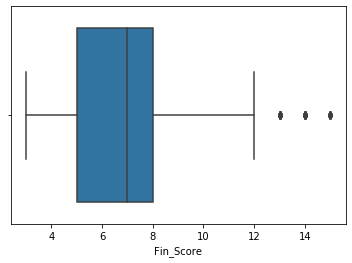

In [38]:
sns.boxplot(x=train_df['Fin_Score'])

Text(0, 0.5, 'Frequency')

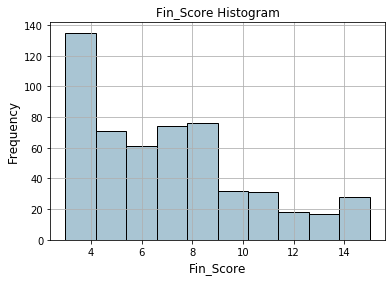

In [39]:
fig, ax = plt.subplots()
train_df['Fin_Score'].hist(color='#A9C5D3', edgecolor='black', grid=True)
ax.set_title('Fin_Score Histogram', fontsize=12)
ax.set_xlabel('Fin_Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [40]:
fin_score_discretised, intervals = pd.qcut(train_df.Fin_Score, 5, labels=None, retbins=True, precision=3, duplicates='raise')
temp = pd.concat([train_df.Fin_Score, fin_score_discretised], axis=1)
temp.columns = ['Fin_Score', 'fin_score_discretised']
temp.groupby('fin_score_discretised')['Fin_Score'].count()

fin_score_discretised
(2.999, 4.0]    135
(4.0, 6.0]      132
(6.0, 7.0]       74
(7.0, 10.0]     108
(10.0, 15.0]     94
Name: Fin_Score, dtype: int64

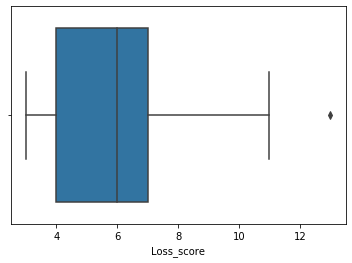

In [41]:
sns.boxplot(x=train_df['Loss_score'])

Text(0, 0.5, 'Frequency')

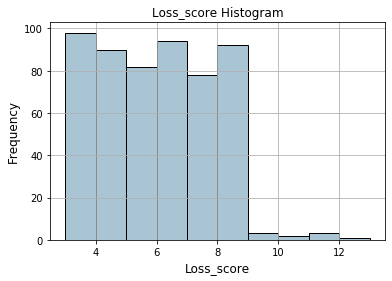

In [42]:
fig, ax = plt.subplots()
train_df['Loss_score'].hist(color='#A9C5D3', edgecolor='black', grid=True)
ax.set_title('Loss_score Histogram', fontsize=12)
ax.set_xlabel('Loss_score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [43]:
loss_score_discretised, intervals = pd.qcut(train_df.Loss_score, 5, labels=None, retbins=True, precision=3, duplicates='raise')
temp = pd.concat([train_df.Loss_score, loss_score_discretised], axis=1)
temp.columns = ['Loss_score', 'loss_score_discretised']
temp.groupby('loss_score_discretised')['Loss_score'].count()

loss_score_discretised
(2.999, 4.0]    188
(4.0, 5.0]       82
(5.0, 6.0]       94
(6.0, 7.0]       78
(7.0, 13.0]     101
Name: Loss_score, dtype: int64

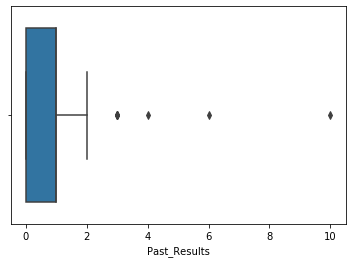

In [44]:
sns.boxplot(x=train_df['Past_Results'])

Text(0, 0.5, 'Frequency')

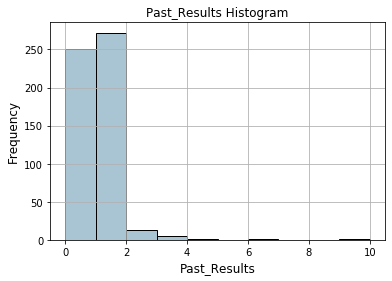

In [45]:
fig, ax = plt.subplots()
train_df['Past_Results'].hist(color='#A9C5D3', edgecolor='black', grid=True)
ax.set_title('Past_Results Histogram', fontsize=12)
ax.set_xlabel('Past_Results', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [49]:
past_results_discretised, intervals = pd.qcut(train_df.Past_Results, 2, labels=None, retbins=True, precision=3, duplicates='raise')
temp = pd.concat([train_df.Past_Results, past_results_discretised], axis=1)
temp.columns = ['Past_Results', 'past_results_discretised']
temp.groupby('past_results_discretised')['Past_Results'].count()

past_results_discretised
(-0.001, 1.0]    522
(1.0, 10.0]       21
Name: Past_Results, dtype: int64

## Data Preprocessing

#### Read train and predict datasets

In [115]:
train_df = pd.read_csv(train_dataset)
predict_df = pd.read_csv(predict_dataset)
print("train_df: {}".format(train_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (543, 8)
predict_df: (233, 7)


#### Extract "IsUnderRisk" field from train_df into NumPy array

In [116]:
train_y = np.array([train_df['IsUnderRisk'].values]).T
train_df.drop(['IsUnderRisk'], inplace=True, axis=1)
print("train_y: {}".format(train_y.shape))

train_y: (543, 1)


#### Feature Engineering

In [117]:
# Combine train and predict dataframes
combined_df = train_df.append(predict_df, sort=False, ignore_index=True)
print(combined_df.shape)

(776, 7)


In [118]:
# Standard Deviation of all score values
combined_df['Location_Score_STD'] = np.std(combined_df['Location_Score'])
combined_df['Internal_Audit_Score_STD'] = np.std(combined_df['Internal_Audit_Score'])
combined_df['External_Audit_Score_STD'] = np.std(combined_df['External_Audit_Score'])
combined_df['Fin_Score_STD'] = np.std(combined_df['Fin_Score'])
combined_df['Loss_score_STD'] = np.std(combined_df['Loss_score'])
combined_df['Past_Results_STD'] = np.std(combined_df['Past_Results'])

# Get difference and mean of different scores
combined_df["Audit_Score_Diff"] = np.power(combined_df["Internal_Audit_Score"] - combined_df["External_Audit_Score"], 2)
combined_df["Average_Audit_Score"] = (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"]) / 2
combined_df["Score_diff1"] = np.power(combined_df["Fin_Score"] - combined_df["Loss_score"], 2)
combined_df["Score_diff2"] = np.power(combined_df["Fin_Score"] - combined_df["Average_Audit_Score"], 2)
combined_df["Score_diff3"] = np.power(combined_df["Loss_score"] - combined_df["Average_Audit_Score"], 2)
combined_df["Cumulative_Score"] = (combined_df['Location_Score'] + combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"] + combined_df["Fin_Score"] + combined_df["Loss_score"]) / 5

In [119]:
# Calculate different score ratios
combined_df["Average_Audit_Score"] = (combined_df["Internal_Audit_Score"] + combined_df["External_Audit_Score"]) / 2
combined_df["Fin_Score/Average_Audit_Score"] = combined_df["Fin_Score"] / combined_df["Average_Audit_Score"]
combined_df["Loss_score/Average_Audit_Score"] = combined_df["Loss_score"] / combined_df["Average_Audit_Score"]
combined_df["Loss_score/Fin_Score"] = combined_df["Loss_score"] / combined_df["Fin_Score"]
combined_df["Fin_Score/Location_Score"] = combined_df["Fin_Score"] / combined_df["Location_Score"]
combined_df["Loss_score/Location_Score"] = combined_df["Loss_score"] / combined_df["Location_Score"]
combined_df["Average_Audit_Score/Location_Score"] = combined_df["Average_Audit_Score"] / combined_df["Location_Score"]
combined_df["Past_Results/Location_Score"] = combined_df["Past_Results"] / combined_df["Location_Score"]

In [120]:
# Box-cox transformation
_, opt_lambda = boxcox(combined_df["Location_Score"])
combined_df['Location_boxcox_lambda_0'] = boxcox((1+combined_df['Location_Score']), lmbda=0)
combined_df['Location_boxcox_lambda_opt'] = boxcox(combined_df['Location_Score'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df["Internal_Audit_Score"])
combined_df['IAS_boxcox_lambda_0'] = boxcox((1+combined_df['Internal_Audit_Score']), lmbda=0)
combined_df['IAS_boxcox_lambda_opt'] = boxcox(combined_df['Internal_Audit_Score'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df["External_Audit_Score"])
combined_df['EAS_boxcox_lambda_0'] = boxcox((1+combined_df['External_Audit_Score']), lmbda=0)
combined_df['EAS_boxcox_lambda_opt'] = boxcox(combined_df['External_Audit_Score'], lmbda=opt_lambda)

_, opt_lambda = boxcox(combined_df["Fin_Score"])
combined_df['Fin_boxcox_lambda_0'] = boxcox((1+combined_df['Fin_Score']), lmbda=0)
combined_df['Fin_boxcox_lambda_opt'] = boxcox(combined_df['Fin_Score'], lmbda=opt_lambda)

In [121]:
fin_score_discretised, intervals = pd.qcut(combined_df.Fin_Score, 5, labels=None, retbins=True, precision=3, duplicates='raise')
combined_df['fin_score_discretised'] = fin_score_discretised

loss_score_discretised, intervals = pd.qcut(combined_df.Loss_score, 5, labels=None, retbins=True, precision=3, duplicates='raise')
combined_df['loss_score_discretised'] = loss_score_discretised

past_results_discretised, intervals = pd.qcut(combined_df.Past_Results, 2, labels=None, retbins=True, precision=3, duplicates='raise')
combined_df['past_results_discretised'] = past_results_discretised

In [124]:
# One-hot encoding
one_hot = pd.get_dummies(combined_df['City'])
combined_df.drop('City', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

one_hot = pd.get_dummies(combined_df['fin_score_discretised'], prefix="Fin")
combined_df.drop('fin_score_discretised', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

one_hot = pd.get_dummies(combined_df['loss_score_discretised'], prefix="Loss")
combined_df.drop('loss_score_discretised', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

one_hot = pd.get_dummies(combined_df['past_results_discretised'], prefix="Past")
combined_df.drop('past_results_discretised', axis = 1, inplace=True)
combined_df = combined_df.join(one_hot)

In [125]:
# Drop redundant columns
combined_df.drop(['Fin_Score','Loss_score','Past_Results'], axis = 1, inplace=True)

#### Create train and predict Numpy arrays and scale them

In [126]:
# Segregate combined_df into train/predict datasets
train_x = combined_df[:543]
predict_x = combined_df[543:]

print("train_x: {}".format(train_x.shape))
print("predict_x: {}".format(predict_x.shape))

train_x: (543, 87)
predict_x: (233, 87)


In [127]:
# Scale the train_x/predict_x arrays
scaler = RobustScaler().fit(train_x)
train_x = scaler.transform(train_x)
predict_x = scaler.transform(predict_x)

In [128]:
train_x_full = train_x.copy()
train_y_full = train_y.copy()

#### Split training data into train/test datasets

In [129]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.095, random_state=1)
for train_index, test_index in sss.split(train_x, train_y):
    train_x, test_x = train_x[train_index], train_x[test_index]
    train_y, test_y = train_y[train_index], train_y[test_index]

print("------------------------- Training Dataset -------------------------")
print("train_x shape: {}".format(train_x.shape))
print("train_y shape: {}".format(train_y.shape))

print("\n------------------------- Test Dataset -------------------------")
print("test_x shape: {}".format(test_x.shape))
print("test_y shape: {}".format(test_y.shape))

------------------------- Training Dataset -------------------------
train_x shape: (491, 87)
train_y shape: (491, 1)

------------------------- Test Dataset -------------------------
test_x shape: (52, 87)
test_y shape: (52, 1)


In [130]:
Xtrain_full, Ytrain_full = train_x_full.copy(), train_y_full.copy()
Xtrain, Ytrain = train_x.copy(), train_y.copy()
Xtest, Ytest = test_x.copy(), test_y.copy()
Xpredict = predict_x.copy()

print("------------------------- Training Dataset -------------------------")
print("Xtrain_full shape: {}".format(Xtrain_full.shape))
print("Ytrain_full shape: {}".format(Ytrain_full.shape))
print("Xtrain shape: {}".format(Xtrain.shape))
print("Ytrain shape: {}".format(Ytrain.shape))

print("\n------------------------- Test Dataset -------------------------")
print("Xtest shape: {}".format(Xtest.shape))
print("Ytest shape: {}".format(Ytest.shape))

print("\n------------------------- Prediction Dataset -------------------------")
print("Xpredict shape: {}".format(Xpredict.shape))

------------------------- Training Dataset -------------------------
Xtrain_full shape: (543, 87)
Ytrain_full shape: (543, 1)
Xtrain shape: (491, 87)
Ytrain shape: (491, 1)

------------------------- Test Dataset -------------------------
Xtest shape: (52, 87)
Ytest shape: (52, 1)

------------------------- Prediction Dataset -------------------------
Xpredict shape: (233, 87)


## Hyperparameter search using Optuna

In [131]:
# Convert Ytest to one-hot encoding
df = pd.DataFrame(Ytest, columns=["IsUnderRisk"])
test_y = pd.get_dummies(df['IsUnderRisk']).values

In [132]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

In [133]:
def objective(trial):
    
    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "num_class": 2,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "is_unbalance": True,
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 35, 200),
        "max_depth": trial.suggest_int("max_depth", 8, 25),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20)
    }
    
    y_pred = 0
    counter = 0
    for train, val in kfold.split(Xtrain, Ytrain):
        counter += 1
    
        train_x, train_y = Xtrain[train], Ytrain[train]
        val_x, val_y = Xtrain[val], Ytrain[val]

        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        model = lgb.train(params, lgtrain, valid_sets=[lgvalidation], 
                          num_boost_round=5000, early_stopping_rounds=200, verbose_eval=False)
        pred = model.predict(Xtest, num_iteration=model.best_iteration)

        y_pred += pred

    y_pred /= float(counter)
    loss = log_loss(test_y, y_pred)
    return loss

In [134]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2020-05-17 21:50:00,948] Finished trial#0 with value: 0.2727319434773888 with parameters: {'learning_rate': 0.055512122865125586, 'lambda_l2': 0.024067092922542752, 'num_leaves': 81, 'max_depth': 22, 'feature_fraction': 0.7878763708741079, 'bagging_fraction': 0.5849856032317944, 'bagging_freq': 5, 'min_child_samples': 11}. Best is trial#0 with value: 0.2727319434773888.
[I 2020-05-17 21:50:04,233] Finished trial#1 with value: 0.2675039025171969 with parameters: {'learning_rate': 0.023019112029391584, 'lambda_l2': 0.8974858586728587, 'num_leaves': 112, 'max_depth': 17, 'feature_fraction': 0.9525839913449399, 'bagging_fraction': 0.6986495980669425, 'bagging_freq': 14, 'min_child_samples': 14}. Best is trial#1 with value: 0.2675039025171969.
[I 2020-05-17 21:50:06,755] Finished trial#2 with value: 0.2909795908983758 with parameters: {'learning_rate': 0.0200309597895919, 'lambda_l2': 0.17256555968396595, 'num_leaves': 187, 'max_depth': 20, 'feature_fraction': 0.7294799185698477, 'baggin

[I 2020-05-17 21:53:29,406] Finished trial#42 with value: 0.2307231065501119 with parameters: {'learning_rate': 0.016502478615509426, 'lambda_l2': 0.03552185688326114, 'num_leaves': 52, 'max_depth': 10, 'feature_fraction': 0.7353256700980124, 'bagging_fraction': 0.9436148406043553, 'bagging_freq': 20, 'min_child_samples': 2}. Best is trial#20 with value: 0.222259474143575.
[I 2020-05-17 21:53:36,720] Finished trial#43 with value: 0.23142331263497157 with parameters: {'learning_rate': 0.01200199623167137, 'lambda_l2': 0.251679207188558, 'num_leaves': 66, 'max_depth': 8, 'feature_fraction': 0.6406130118839143, 'bagging_fraction': 0.9942156730104629, 'bagging_freq': 18, 'min_child_samples': 4}. Best is trial#20 with value: 0.222259474143575.
[I 2020-05-17 21:53:41,381] Finished trial#44 with value: 0.22624400502729575 with parameters: {'learning_rate': 0.07847974220812547, 'lambda_l2': 0.05538390650148621, 'num_leaves': 76, 'max_depth': 9, 'feature_fraction': 0.6655248078317579, 'bagging_

[I 2020-05-17 21:57:23,982] Finished trial#84 with value: 0.23649478997942358 with parameters: {'learning_rate': 0.05269002606874538, 'lambda_l2': 0.005179012576458786, 'num_leaves': 67, 'max_depth': 15, 'feature_fraction': 0.7145237347534771, 'bagging_fraction': 0.8089993258362358, 'bagging_freq': 13, 'min_child_samples': 1}. Best is trial#52 with value: 0.20627523626277228.
[I 2020-05-17 21:57:30,022] Finished trial#85 with value: 0.2291722932631139 with parameters: {'learning_rate': 0.0493373894462091, 'lambda_l2': 0.003985636049875879, 'num_leaves': 80, 'max_depth': 13, 'feature_fraction': 0.746795409721718, 'bagging_fraction': 0.8112665846882284, 'bagging_freq': 12, 'min_child_samples': 3}. Best is trial#52 with value: 0.20627523626277228.
[I 2020-05-17 21:57:35,217] Finished trial#86 with value: 0.24112527467655964 with parameters: {'learning_rate': 0.07043821625910153, 'lambda_l2': 0.016528142205815947, 'num_leaves': 56, 'max_depth': 14, 'feature_fraction': 0.7267257538859263, '

In [135]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("Value: {}".format(trial.value))

print("Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
Value: 0.20627523626277228
Params: 
 learning_rate: 0.06187407624330923
 lambda_l2: 0.007218808441747305
 num_leaves: 83
 max_depth: 13
 feature_fraction: 0.8216994738557187
 bagging_fraction: 0.7392179518993611
 bagging_freq: 10
 min_child_samples: 1


## Build the model

In [136]:
# Define model hyperparameters
params = {}
params["objective"] = 'multiclass'
params["metric"] = 'multi_logloss'
params["num_class"] = 2
params["is_unbalance"] = True
params["boosting"] = 'gbdt'
params["learning_rate"] = 0.06
params["lambda_l2"] = 0.007
params["num_leaves"] = 83
params["max_depth"] = 13
params["feature_fraction"] = 0.82
params["bagging_fraction"] = 0.74
params["bagging_freq"] = 10
params["min_data_in_leaf"] = 1
params["bagging_seed"] = 10
params["verbosity"] = -1
num_rounds = 5000

In [137]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [138]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain, Ytrain):
    counter += 1

    train_x, train_y = Xtrain[train], Ytrain[train]
    val_x, val_y = Xtrain[val], Ytrain[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xtest, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.387221
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[40]	valid_0's multi_logloss: 0.319662
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33]	valid_0's multi_logloss: 0.348224
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.252884
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	valid_0's multi_logloss: 0.297664


## Validate the model

In [139]:
#Print log_loss
loss = log_loss(test_y, y_pred)
print('Overall log_loss of model:', loss)

Overall log_loss of model: 0.23548267127244807


In [140]:
#Print accuracy
y_pred_binary = np.array([np.argmax(y_pred, axis=1)]).T
acc_score = accuracy_score(Ytest, y_pred_binary)
f1 = f1_score(Ytest, y_pred_binary)
print('Overall accuracy:', acc_score)
print('Overall F1-Score:', f1)

Overall accuracy: 0.8653846153846154
Overall F1-Score: 0.8923076923076922


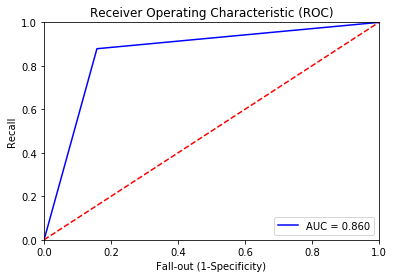

AUC score: 0.8604465709728867


In [141]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(Ytest, y_pred_binary)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

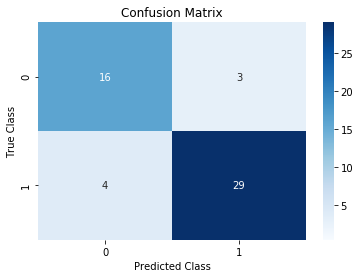

In [142]:
#Print Confusion Matrix
cm = confusion_matrix(Ytest, y_pred_binary)
labels = ['0', '1']
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.5);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Train model on entire data

In [ ]:
# Define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
y_pred = 0

In [ ]:
# Train the model using K-fold
counter = 0

for train, val in kfold.split(Xtrain_full, Ytrain_full):
    counter += 1

    train_x, train_y = Xtrain_full[train], Ytrain_full[train]
    val_x, val_y = Xtrain_full[val], Ytrain_full[val]

    lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
    lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

    model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgvalidation], early_stopping_rounds=200, verbose_eval=1000)
    pred = model.predict(Xpredict, num_iteration=model.best_iteration)

    y_pred += pred

y_pred /= float(counter)

## Create submission file

In [ ]:
submit_df = pd.DataFrame(y_pred, columns=['0','1'])
submit_df.head()

In [ ]:
submit_df.to_excel("Predictions/predictions_v13.xlsx", index=False)